In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [3]:
df.info()
df.describe(include='all')
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

In [4]:
df = df.drop(columns=["show_id", "title", "director", "cast", "description"])

In [5]:
df = df.dropna(subset=["country", "rating", "date_added"])
df.reset_index(drop=True, inplace=True)

In [6]:
def convert_duration(val):
    if "min" in val:
        return int(val.replace(" min", ""))
    elif "Season" in val:
        return int(val.split()[0]) * 60  # approx 1 season = 60 mins
    else:
        return np.nan

df["duration_mins"] = df["duration"].apply(convert_duration)
df = df.drop(columns=["duration"])

In [7]:
label_cols = ["type", "country", "rating"]
le = LabelEncoder()

for col in label_cols:
    df[col] = le.fit_transform(df[col])

# Split multiple genres and only use the first one
df["main_genre"] = df["listed_in"].apply(lambda x: x.split(",")[0])
df["main_genre"] = le.fit_transform(df["main_genre"])
df = df.drop(columns=["listed_in"])

In [8]:
cluster_data = df[["type", "release_year", "country", "rating", "duration_mins", "main_genre"]]
cluster_data = cluster_data.dropna()

In [9]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

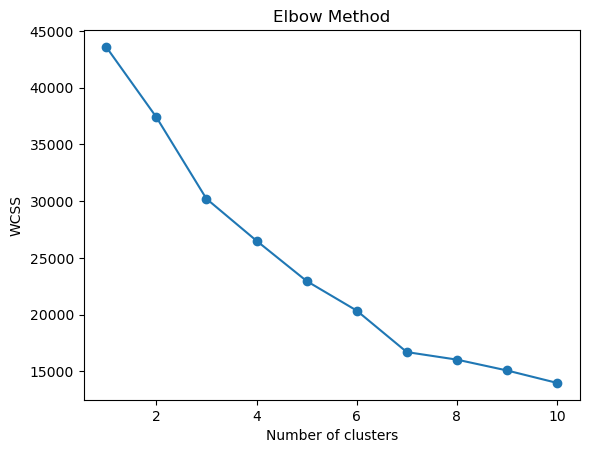

In [10]:
# Elbow Method to find optimal K
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(scaled_data)
    wcss.append(km.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()


In [11]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
df["cluster"] = clusters


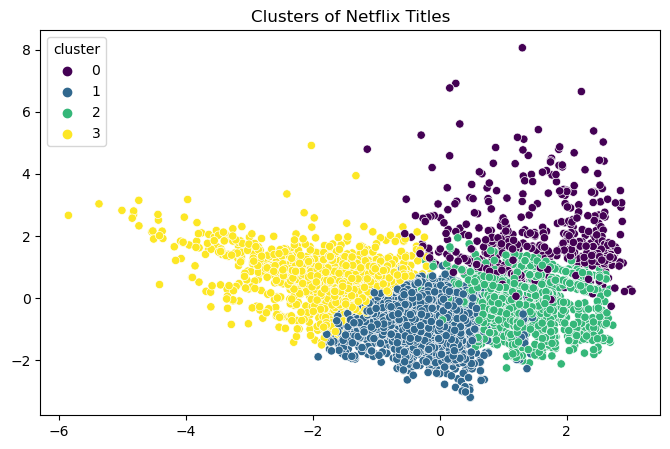

In [12]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df["cluster"], palette="viridis")
plt.title("Clusters of Netflix Titles")
plt.show()


In [14]:
# Analyze clusters
print(df.groupby("cluster").mean(numeric_only=True))


             type     country  release_year    rating  duration_mins  \
cluster                                                                
0        0.602410  510.103079   2015.978581  7.668005     160.923695   
1        0.000000  326.192597   2015.855251  7.515498      99.333133   
2        1.000000  360.176542   2016.449819  7.892382      79.588875   
3        0.011681  481.971447   2005.414666  4.474367     107.718365   

         main_genre  
cluster              
0         25.200803  
1          8.999097  
2         11.706167  
3          7.029202  
